In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import os
from dataclasses import dataclass
import json
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from llamawrapper import load_unemb_only, LlamaHelper
import seaborn as sns
from scipy.stats import bootstrap
from utils import plot_ci, plot_ci_plus_heatmap
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer
# fix random seed
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)
sys.path.append('../tuned-lens')
from tuned_lens.nn.lenses import TunedLens,LogitLens

In [3]:
input_lang = 'fr'
target_lang = 'fr'
model_size = '7b'
prefix = "./data/langs/"
type = 'logit'

In [4]:
# Parameters
model_size = "7b"
target_lang = "ru"
input_lang = "fr"
type = "tuned"


In [5]:
df_en_input = pd.read_csv(f'{prefix}{input_lang}/clean.csv').reindex()
df_en_target = pd.read_csv(f'{prefix}{target_lang}/clean.csv').reindex()
llama = AutoModelForCausalLM.from_pretrained(  # type: ignore
                f"meta-llama/Llama-2-{model_size}-hf",
                device_map={"": "cuda"},
                revision="main",
                torch_dtype="auto",
                local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )
    
latent="en"
if type == 'logit':
    llama_lens = LogitLens.from_model(llama).to("cuda")
    out_dir = f'./visuals/logit'
if type == 'tuned':
    llama_lens = TunedLens.from_model_and_pretrained(llama,f"meta-llama/Llama-2-{model_size}-hf").to("cuda")
    out_dir = f'./visuals/tuned'
if type == 'tuned-chinese':
    llama_lens = TunedLens.from_model_and_pretrained(llama,"../tuned-lens/my_lenses/chinese").to("cuda")
    out_dir = f'./visuals/tuned-chinese'
    latent = 'zh'
tokenizer = AutoTokenizer.from_pretrained(
                f"meta-llama/Llama-2-7b-hf",local_files_only="true",cache_dir="/mnt/ssd-1/hf_cache/"
            )

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

params.pt AlignmentResearch/tuned-lens space main lens/meta-llama/Llama-2-7b-hf None


params.pt:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

(…)ens/meta-llama/Llama-2-7b-hf/config.json:   0%|          | 0.00/258 [00:00<?, ?B/s]

In [6]:
unemb = nn.Sequential(llama.model.norm, llama.lm_head)
print(unemb)
# prepare for energy plots
U = list(unemb[1].parameters())[0].detach().cpu().float()
weights = list(unemb[0].parameters())[0].detach().cpu().float()
print(f'U {U.shape} weights {weights.unsqueeze(0).shape}')
U_weighted = U.clone() 
#U_weighted = U_weighted / ((U_weighted**2).mean(dim=1, keepdim=True))**0.5
U_weighted *= weights.unsqueeze(0)
U_normalized = U_weighted / ((U_weighted**2).sum(dim=1, keepdim=True))**0.5
v = U.shape[0]
TT = U_normalized.T @ U_normalized
avgUU = (((U_normalized.T @ U_normalized)**2).sum() / v**2)**0.5
print(avgUU.item())

Sequential(
  (0): LlamaRMSNorm()
  (1): Linear(in_features=4096, out_features=32000, bias=False)
)
U torch.Size([32000, 4096]) weights torch.Size([1, 4096])


0.058621685951948166


In [7]:
count = 0
for idx, word in enumerate(df_en_target['word_translation']):
    if word in tokenizer.get_vocab() or '▁'+word in tokenizer.get_vocab():
        count += 1

print(f'for {target_lang} {count} of {len(df_en_target)} are single tokens')

if input_lang == target_lang:
    df_en_target_input = df_en_target.copy()
    df_en_target_input.rename(columns={'word_original': 'en', 
                                f'word_translation': target_lang if target_lang != 'en' else 'en_tgt'}, 
                                inplace=True)
else:
    df_en_target_input = df_en_target.merge(df_en_input, on=['word_original'], suffixes=(f'_{target_lang}', f'_{input_lang}'))
    df_en_target_input.rename(columns={'word_original': 'en', 
                                f'word_translation_{target_lang}': target_lang if target_lang != 'en' else 'en_tgt', 
                                f'word_translation_{input_lang}': input_lang if input_lang != 'en' else 'en_in'}, 
                                inplace=True)
# delete all rows where en is contained in de or fr
if target_lang != 'en':
    for i, row in df_en_target_input.iterrows():
        if row['en'].lower() in row[target_lang].lower():
            df_en_target_input.drop(i, inplace=True)

print(f'final length of df_en_{target_lang}_{input_lang}: {len(df_en_target_input)}')

for ru 15 of 115 are single tokens
final length of df_en_ru_fr: 104


In [8]:
df_en_target_input

,lang_ru,en,ru,blank_prompt_original_ru,blank_prompt_translation_ru,blank_prompt_translation_masked_ru,error_ru,lang_fr,fr,blank_prompt_original_fr,blank_prompt_translation_fr,blank_prompt_translation_masked_fr,error_fr
0,ru,cloud,облако,"A ""cloud"" is a visible mass of condensed water...",Облако - это видимая масса конденсированного в...,"""___"" - это видимая масса конденсированного во...",no error,fr,nuage,"A ""cloud"" is a visible mass of condensed water...","Un ""nuage"" est une masse visible de vapeur d'e...","Un ""___"" est une masse visible de vapeur d'eau...",no error
1,ru,bag,сумка,"A ""bag"" is used to carry items. Answer: ""bag"".",Сумка используется для переноски предметов. От...,"""___"" используется для переноски предметов. От...",no error,fr,sac,"A ""bag"" is used to carry items. Answer: ""bag"".","Un ""sac"" est utilisé pour transporter des obje...","Un ""___"" est utilisé pour transporter des obje...",no error
2,ru,mouth,рот,"A ""mouth"" is used to eat food and speak. Answe...",Рот используется для приема пищи и речи. Ответ...,"""___"" используется для приема пищи и речи. Отв...",no error,fr,bouche,"A ""mouth"" is used to eat food and speak. Answe...","La ""bouche"" sert à manger et à parler. Réponse...","La ""___"" sert à manger et à parler. Réponse : ...",no error
3,ru,soil,почва,"""A ""soil"" is used for planting trees and crops...","""Почва"" используется для посадки деревьев и вы...","""___"" используется для посадки деревьев и выра...",no error,fr,sol,"""A ""soil"" is used for planting trees and crops...","""Un ""sol"" est utilisé pour planter des arbres ...","""Un ""___"" est utilisé pour planter des arbres ...",no error
4,ru,mountain,гора,"A ""mountain"" is a large natural elevation of t...",Гора - это крупное естественное возвышение зем...,"""___"" - это крупное естественное возвышение зе...",no error,fr,montagne,"A ""mountain"" is a large natural elevation of t...","Une ""montagne"" est une grande élévation nature...","Une ""___"" est une grande élévation naturelle d...",no error
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,ru,person,человек,"'A ""person"" is a human being regarded as an in...","""Человек"" - это человеческое существо, рассмат...","""___"" - это человеческое существо, рассматрива...",no error,fr,personne,"'A ""person"" is a human being regarded as an in...","Une ""personne"" est un être humain considéré co...","Une ""___"" est un être humain considéré comme u...",no error
100,ru,office,офис,"An ""office"" is a place where people usually do...","Офис - это место, где люди обычно выполняют св...","""___"" - это место, где люди обычно выполняют с...",no error,fr,bureau,"An ""office"" is a place where people usually do...","Un ""bureau"" est un endroit où les gens font ha...","Un ""___"" est un endroit où les gens font habit...",no error
101,ru,sound,звук,"A ""sound"" is something we hear. Answer: ""sound"".","Звук - это то, что мы слышим. Ответ: ""звук"".","""___"" - это то, что мы слышим. Ответ: ""звук"".",no error,fr,son,"A ""sound"" is something we hear. Answer: ""sound"".","Un ""son"" est quelque chose que l'on entend. Ré...","Un ""___"" est quelque chose que l'on entend. Ré...",no error
102,ru,power,власть,"""A ""power"" is used to control or influence peo...","""Власть"" используется для контроля или влияния...","""___"" используется для контроля или влияния на...",no error,fr,pouvoir,"""A ""power"" is used to control or influence peo...","""Un ""pouvoir"" est utilisé pour contrôler ou in...","""Un ""___"" est utilisé pour contrôler ou influe...",no error


In [9]:
def token_prefixes(token_str: str):
    n = len(token_str)
    tokens = [token_str[:i] for i in range(1, n+1)]
    return tokens 

def add_spaces(tokens):
    return ['▁' + t for t in tokens] + tokens

def capitalizations(tokens):
    return list(set(tokens))

def unicode_prefix_tokid(zh_char = "云", tokenizer=tokenizer):
    start = zh_char.encode().__str__()[2:-1].split('\\x')[1]
    unicode_format = '<0x%s>'
    start_key = unicode_format%start.upper()
    if start_key in tokenizer.get_vocab():
        return tokenizer.get_vocab()[start_key]
    return None

def process_tokens(token_str: str, tokenizer, lang):
    with_prefixes = token_prefixes(token_str)
    with_spaces = add_spaces(with_prefixes)
    with_capitalizations = capitalizations(with_spaces)
    final_tokens = []
    for tok in with_capitalizations:
        if tok in tokenizer.get_vocab():
            final_tokens.append(tokenizer.get_vocab()[tok])
    if lang in ['zh', 'ru']:
        tokid = unicode_prefix_tokid(token_str, tokenizer)
        if tokid is not None:
            final_tokens.append(tokid)
    return final_tokens

In [10]:

id2voc = {id:voc for voc, id in tokenizer.get_vocab().items()}
def get_tokens(token_ids, id2voc=id2voc):
    return [id2voc[tokid] for tokid in token_ids]

def compute_entropy(probas):
    return (-probas*torch.log2(probas)).sum(dim=-1)

lang2name = {'fr': 'Français', 'de': 'Deutsch', 'ru': 'Русский', 'en': 'English', 'zh': '中文'}
def sample(df, ind, k=5, tokenizer=tokenizer, lang1='fr', lang2='de', lang_latent=latent):
    df = df.reset_index(drop=True)
    temp = df[df.index!=ind]
    sample = pd.concat([temp.sample(k-1), df[df.index==ind]], axis=0)
    prompt = ""
    for idx, (df_idx, row) in enumerate(sample.iterrows()):
        if idx < k-1:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "{row[lang2]}"\n'
        else:
            prompt += f'{lang2name[lang1]}: "{row[lang1]}" - {lang2name[lang2]}: "'
            in_token_str = row[lang1]
            out_token_str = row[lang2]
            out_token_id = process_tokens(out_token_str, tokenizer, lang2)
            latent_token_str = row[lang_latent]
            latent_token_id = process_tokens(latent_token_str, tokenizer, latent)
            intersection = set(out_token_id).intersection(set(latent_token_id))
            if len(out_token_id) == 0 or len(latent_token_id) == 0:
                yield None
            if lang2 != 'en' and len(intersection) > 0:
                yield None
            yield {'prompt': prompt, 
                'out_token_id': out_token_id, 
                'out_token_str': out_token_str,
                'latent_token_id': latent_token_id, 
                'latent_token_str': latent_token_str, 
                'in_token_str': in_token_str}

In [11]:
dataset = []
for ind in tqdm(range(len(df_en_target_input))):
    d = next(sample(df_en_target_input, ind, lang1=input_lang, lang2=target_lang))
    if d is None:
        continue
    dataset.append(d)

  0%|                                                                                                                                                                                                                       | 0/104 [00:00<?, ?it/s]

  1%|█▉                                                                                                                                                                                                             | 1/104 [00:00<00:44,  2.29it/s]

  2%|███▉                                                                                                                                                                                                           | 2/104 [00:00<00:32,  3.16it/s]

  3%|█████▉                                                                                                                                                                                                         | 3/104 [00:00<00:28,  3.50it/s]

  4%|███████▉                                                                                                                                                                                                       | 4/104 [00:01<00:29,  3.35it/s]

  5%|█████████▉                                                                                                                                                                                                     | 5/104 [00:01<00:28,  3.50it/s]

  6%|███████████▉                                                                                                                                                                                                   | 6/104 [00:01<00:26,  3.73it/s]

  7%|█████████████▉                                                                                                                                                                                                 | 7/104 [00:01<00:23,  4.09it/s]

  8%|███████████████▉                                                                                                                                                                                               | 8/104 [00:02<00:22,  4.30it/s]

  9%|█████████████████▉                                                                                                                                                                                             | 9/104 [00:02<00:22,  4.18it/s]

 10%|███████████████████▊                                                                                                                                                                                          | 10/104 [00:02<00:20,  4.61it/s]

 11%|█████████████████████▊                                                                                                                                                                                        | 11/104 [00:02<00:22,  4.13it/s]

 12%|███████████████████████▊                                                                                                                                                                                      | 12/104 [00:03<00:21,  4.35it/s]

 12%|█████████████████████████▊                                                                                                                                                                                    | 13/104 [00:03<00:19,  4.59it/s]

 13%|███████████████████████████▋                                                                                                                                                                                  | 14/104 [00:03<00:18,  4.78it/s]

 14%|█████████████████████████████▋                                                                                                                                                                                | 15/104 [00:03<00:18,  4.80it/s]

 15%|███████████████████████████████▋                                                                                                                                                                              | 16/104 [00:03<00:17,  4.98it/s]

 16%|█████████████████████████████████▋                                                                                                                                                                            | 17/104 [00:04<00:17,  4.99it/s]

 17%|███████████████████████████████████▋                                                                                                                                                                          | 18/104 [00:04<00:16,  5.18it/s]

 18%|█████████████████████████████████████▋                                                                                                                                                                        | 19/104 [00:04<00:16,  5.22it/s]

 19%|███████████████████████████████████████▌                                                                                                                                                                      | 20/104 [00:04<00:16,  5.13it/s]

 20%|█████████████████████████████████████████▌                                                                                                                                                                    | 21/104 [00:04<00:16,  5.07it/s]

 21%|███████████████████████████████████████████▌                                                                                                                                                                  | 22/104 [00:04<00:15,  5.29it/s]

 22%|█████████████████████████████████████████████▌                                                                                                                                                                | 23/104 [00:05<00:15,  5.30it/s]

 23%|███████████████████████████████████████████████▌                                                                                                                                                              | 24/104 [00:05<00:16,  4.74it/s]

 24%|█████████████████████████████████████████████████▌                                                                                                                                                            | 25/104 [00:05<00:16,  4.74it/s]

 25%|███████████████████████████████████████████████████▌                                                                                                                                                          | 26/104 [00:05<00:17,  4.34it/s]

 26%|█████████████████████████████████████████████████████▍                                                                                                                                                        | 27/104 [00:06<00:16,  4.67it/s]

 27%|███████████████████████████████████████████████████████▍                                                                                                                                                      | 28/104 [00:06<00:15,  4.88it/s]

 28%|█████████████████████████████████████████████████████████▍                                                                                                                                                    | 29/104 [00:06<00:15,  4.90it/s]

 29%|███████████████████████████████████████████████████████████▍                                                                                                                                                  | 30/104 [00:06<00:15,  4.91it/s]

 30%|█████████████████████████████████████████████████████████████▍                                                                                                                                                | 31/104 [00:06<00:14,  5.12it/s]

 31%|███████████████████████████████████████████████████████████████▍                                                                                                                                              | 32/104 [00:07<00:14,  4.88it/s]

 32%|█████████████████████████████████████████████████████████████████▎                                                                                                                                            | 33/104 [00:07<00:13,  5.28it/s]

 33%|███████████████████████████████████████████████████████████████████▎                                                                                                                                          | 34/104 [00:07<00:13,  5.23it/s]

 34%|█████████████████████████████████████████████████████████████████████▎                                                                                                                                        | 35/104 [00:07<00:13,  5.11it/s]

 35%|███████████████████████████████████████████████████████████████████████▎                                                                                                                                      | 36/104 [00:07<00:13,  5.21it/s]

 36%|█████████████████████████████████████████████████████████████████████████▎                                                                                                                                    | 37/104 [00:07<00:12,  5.50it/s]

 37%|███████████████████████████████████████████████████████████████████████████▎                                                                                                                                  | 38/104 [00:08<00:12,  5.17it/s]

 38%|█████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 39/104 [00:08<00:11,  5.59it/s]

 38%|███████████████████████████████████████████████████████████████████████████████▏                                                                                                                              | 40/104 [00:08<00:11,  5.48it/s]

 39%|█████████████████████████████████████████████████████████████████████████████████▏                                                                                                                            | 41/104 [00:08<00:12,  5.22it/s]

 40%|███████████████████████████████████████████████████████████████████████████████████▏                                                                                                                          | 42/104 [00:08<00:11,  5.40it/s]

 41%|█████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                        | 43/104 [00:09<00:11,  5.49it/s]

 42%|███████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                      | 44/104 [00:09<00:11,  5.43it/s]

 43%|█████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                                    | 45/104 [00:09<00:11,  5.14it/s]

 44%|███████████████████████████████████████████████████████████████████████████████████████████                                                                                                                   | 46/104 [00:09<00:11,  5.07it/s]

 45%|█████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                 | 47/104 [00:09<00:11,  5.08it/s]

 46%|███████████████████████████████████████████████████████████████████████████████████████████████                                                                                                               | 48/104 [00:10<00:11,  4.94it/s]

 47%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                             | 49/104 [00:10<00:12,  4.56it/s]

 48%|███████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                           | 50/104 [00:10<00:12,  4.48it/s]

 49%|█████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                         | 51/104 [00:10<00:11,  4.46it/s]

 50%|███████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                       | 52/104 [00:11<00:11,  4.52it/s]

 51%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                     | 53/104 [00:11<00:11,  4.53it/s]

 52%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                   | 54/104 [00:11<00:10,  4.61it/s]

 53%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 55/104 [00:11<00:10,  4.71it/s]

 54%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                               | 56/104 [00:11<00:10,  4.70it/s]

 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                             | 57/104 [00:12<00:10,  4.43it/s]

 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                           | 58/104 [00:12<00:10,  4.51it/s]

 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                         | 59/104 [00:12<00:10,  4.31it/s]

 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 60/104 [00:12<00:11,  3.99it/s]

 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                     | 61/104 [00:13<00:11,  3.64it/s]

 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                   | 62/104 [00:13<00:11,  3.78it/s]

 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                 | 63/104 [00:13<00:11,  3.71it/s]

 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                               | 64/104 [00:13<00:09,  4.06it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                             | 65/104 [00:14<00:08,  4.38it/s]

 63%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                           | 66/104 [00:14<00:08,  4.51it/s]

 64%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                         | 67/104 [00:14<00:08,  4.44it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                       | 68/104 [00:14<00:09,  3.76it/s]

 66%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                     | 69/104 [00:15<00:08,  4.08it/s]

 67%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                   | 70/104 [00:15<00:08,  3.97it/s]

 68%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                 | 71/104 [00:15<00:07,  4.32it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                               | 72/104 [00:15<00:07,  4.43it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                             | 73/104 [00:16<00:07,  4.30it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                           | 74/104 [00:16<00:06,  4.34it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 75/104 [00:16<00:06,  4.26it/s]

 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                       | 76/104 [00:16<00:06,  4.25it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                     | 77/104 [00:17<00:06,  3.91it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 78/104 [00:17<00:06,  4.20it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                 | 79/104 [00:17<00:05,  4.47it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                               | 80/104 [00:17<00:05,  4.15it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                             | 81/104 [00:18<00:05,  3.90it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 82/104 [00:18<00:05,  3.91it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                         | 83/104 [00:18<00:05,  3.97it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                       | 84/104 [00:18<00:05,  3.60it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                     | 85/104 [00:19<00:04,  4.14it/s]

 83%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                   | 86/104 [00:19<00:04,  3.84it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 87/104 [00:19<00:04,  4.12it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 88/104 [00:19<00:03,  4.17it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 89/104 [00:20<00:03,  4.06it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                           | 90/104 [00:20<00:03,  4.09it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                         | 91/104 [00:20<00:03,  3.98it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                       | 92/104 [00:20<00:03,  3.49it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 93/104 [00:21<00:03,  3.52it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 94/104 [00:21<00:02,  3.49it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 95/104 [00:21<00:02,  3.50it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 96/104 [00:22<00:02,  3.21it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 97/104 [00:22<00:02,  3.34it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 98/104 [00:22<00:01,  3.35it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 99/104 [00:22<00:01,  3.48it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 100/104 [00:23<00:01,  3.28it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 101/104 [00:23<00:00,  3.35it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 102/104 [00:23<00:00,  3.51it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 103/104 [00:24<00:00,  3.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:24<00:00,  3.53it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 104/104 [00:24<00:00,  4.27it/s]

In [12]:
df = pd.DataFrame(dataset)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
df.to_csv(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_dataset.csv', index=False)

In [13]:
df

,prompt,out_token_id,out_token_str,latent_token_id,latent_token_str,in_token_str
0,"Français: ""fleur"" - Русский: ""цветок""\nFrançai...","[29904, 5055, 614, 4389, 1604, 211]",облако,"[9274, 274, 23642, 29883, 15126, 9570, 17184, ...",cloud,nuage
1,"Français: ""génération"" - Русский: ""поколение""\...","[531, 3404, 29935, 2937, 212]",сумка,"[9922, 29890, 289, 2291, 23156, 19548]",bag,sac
2,"Français: ""riz"" - Русский: ""рис""\nFrançais: ""t...","[576, 29927, 1561, 8201, 212]",рот,"[29885, 21026, 2730, 286, 29442, 4346, 13394]",mouth,bouche
3,"Français: ""sud"" - Русский: ""юг""\nFrançais: ""va...","[29964, 469, 1268, 18752, 733, 211]",почва,"[29879, 22473, 577, 269, 578]",soil,sol
4,"Français: ""onde"" - Русский: ""волна""\nFrançais:...","[1214, 588, 17310, 1084, 24856, 29969, 211]",гора,"[29885, 2730, 14378, 286, 16476, 29442, 5766, ...",mountain,montagne
...,...,...,...,...,...,...
99,"Français: ""deux"" - Русский: ""два""\nFrançais: ""...","[14347, 9831, 2950, 29981, 19084, 2493, 1093, ...",человек,"[412, 639, 546, 3736, 282, 1236, 6774, 29886, ...",person,personne
100,"Français: ""structure"" - Русский: ""структура""\n...","[29904, 614, 211]",офис,"[29877, 1283, 310, 8034, 20205, 288, 2696, 974...",office,bureau
101,"Français: ""exemple"" - Русский: ""пример""\nFranç...","[29351, 27643, 29972, 754, 211]",звук,"[29879, 6047, 3669, 29802, 577, 269, 578]",sound,son
102,"Français: ""personne"" - Русский: ""человек""\nFra...","[29942, 490, 8672, 211]",власть,"[1129, 772, 282, 13519, 4764, 29886, 3081, 12248]",power,pouvoir


In [14]:
def get_logits(model, prompt,lens):
    inputs = tokenizer(prompt, return_tensors="pt").to('cuda')
    output = llama(inputs.input_ids, output_hidden_states=True)
    hidden_states = output.hidden_states[:-1]
    final_lps = output.logits.log_softmax(dim=-1)
    tensors=[]
    for i in range(32):
        h = hidden_states[i].squeeze(0)
        tensors+=[lens(h, idx=i).detach().cpu()]
    tensors= torch.stack(tensors)  
    hidden_states = torch.stack(hidden_states).squeeze(1).detach().cpu()
    return tensors,hidden_states
        

In [15]:
in_token_probs = []
latent_token_probs = []
out_token_probs = []
entropy = []
energy = []
latents_all = []

for idx, d in tqdm(enumerate(dataset)):
    logits,latents = get_logits(llama, d['prompt'],llama_lens)
    last = logits[:, -1, :].float().softmax(dim=-1).detach().cpu()
    latent_token_probs += [last[:, torch.tensor(d['latent_token_id'])].sum(dim=-1)]
    out_token_probs += [last[:, torch.tensor(d['out_token_id'])].sum(dim=-1)]
    entropy += [compute_entropy(last)]
    latents_all += [latents[:, -1, :].float().detach().cpu().clone()]
    latents_normalized = latents[:, -1, :].float()
    latents_normalized = latents_normalized / (((latents_normalized**2).mean(dim=-1, keepdim=True))**0.5)
    latents_normalized /= (latents_normalized.norm(dim=-1, keepdim=True))
    norm = ((U_normalized @ latents_normalized.T)**2).mean(dim=0)**0.5
    energy += [norm/avgUU]

latent_token_probs = torch.stack(latent_token_probs)
out_token_probs = torch.stack(out_token_probs)
entropy = torch.stack(entropy)
energy = torch.stack(energy)
latents = torch.stack(latents_all)

0it [00:00, ?it/s]

1it [00:00,  1.03it/s]

2it [00:01,  2.00it/s]

3it [00:01,  2.81it/s]

4it [00:01,  3.31it/s]

5it [00:01,  3.60it/s]

6it [00:01,  4.08it/s]

7it [00:02,  4.72it/s]

8it [00:02,  4.79it/s]

9it [00:02,  4.64it/s]

10it [00:02,  4.91it/s]

11it [00:02,  5.22it/s]

12it [00:03,  5.22it/s]

13it [00:03,  5.17it/s]

14it [00:03,  5.45it/s]

15it [00:03,  5.60it/s]

16it [00:03,  5.49it/s]

17it [00:03,  5.78it/s]

18it [00:04,  5.67it/s]

19it [00:04,  5.51it/s]

20it [00:04,  5.81it/s]

21it [00:04,  5.47it/s]

22it [00:04,  5.29it/s]

23it [00:05,  5.60it/s]

24it [00:05,  5.66it/s]

25it [00:05,  5.57it/s]

26it [00:05,  5.37it/s]

27it [00:05,  4.82it/s]

28it [00:06,  4.98it/s]

29it [00:06,  5.19it/s]

30it [00:06,  5.30it/s]

31it [00:06,  5.30it/s]

32it [00:06,  4.98it/s]

33it [00:07,  4.96it/s]

34it [00:07,  5.30it/s]

35it [00:07,  5.51it/s]

36it [00:07,  5.57it/s]

37it [00:07,  5.34it/s]

38it [00:07,  5.28it/s]

39it [00:08,  5.01it/s]

40it [00:08,  5.02it/s]

41it [00:08,  5.32it/s]

42it [00:08,  5.41it/s]

43it [00:08,  5.44it/s]

44it [00:09,  5.62it/s]

45it [00:09,  5.71it/s]

46it [00:09,  5.80it/s]

47it [00:09,  5.86it/s]

48it [00:09,  5.51it/s]

49it [00:09,  5.33it/s]

50it [00:10,  5.81it/s]

51it [00:10,  5.85it/s]

52it [00:10,  5.78it/s]

53it [00:10,  5.64it/s]

54it [00:10,  5.90it/s]

55it [00:10,  5.73it/s]

56it [00:11,  5.33it/s]

57it [00:11,  5.44it/s]

58it [00:11,  5.10it/s]

59it [00:11,  5.42it/s]

60it [00:11,  5.52it/s]

61it [00:12,  5.57it/s]

62it [00:12,  5.86it/s]

63it [00:12,  5.98it/s]

64it [00:12,  5.89it/s]

65it [00:12,  5.91it/s]

66it [00:12,  6.24it/s]

67it [00:12,  6.44it/s]

68it [00:13,  6.17it/s]

69it [00:13,  6.19it/s]

70it [00:13,  6.43it/s]

71it [00:13,  6.47it/s]

72it [00:13,  5.61it/s]

73it [00:13,  6.08it/s]

74it [00:14,  6.35it/s]

75it [00:14,  6.22it/s]

76it [00:14,  6.23it/s]

77it [00:14,  6.41it/s]

78it [00:14,  6.37it/s]

79it [00:14,  6.18it/s]

80it [00:15,  6.41it/s]

81it [00:15,  6.46it/s]

82it [00:15,  5.97it/s]

83it [00:15,  6.17it/s]

84it [00:15,  5.89it/s]

85it [00:15,  5.87it/s]

86it [00:16,  5.54it/s]

87it [00:16,  6.04it/s]

88it [00:16,  6.31it/s]

89it [00:16,  6.09it/s]

90it [00:16,  6.41it/s]

91it [00:16,  6.20it/s]

92it [00:17,  5.98it/s]

93it [00:17,  5.48it/s]

94it [00:17,  6.00it/s]

95it [00:17,  6.10it/s]

96it [00:17,  5.72it/s]

97it [00:18,  5.32it/s]

98it [00:18,  5.28it/s]

99it [00:18,  5.51it/s]

100it [00:18,  5.78it/s]

101it [00:18,  5.55it/s]

102it [00:18,  5.65it/s]

103it [00:19,  5.57it/s]

104it [00:19,  5.57it/s]

104it [00:19,  5.40it/s]

/mnt/ssd-1/gpaulo/llm-latent-language/utils.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


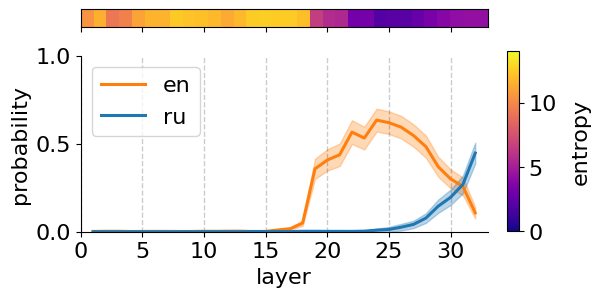

In [16]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}
fig, ax, ax2 = plot_ci_plus_heatmap(latent_token_probs, entropy, latent, color='tab:orange', tik_step=size2tik[model_size], do_colorbar=True, #, do_colorbar=(model_size=='70b'),
nums=[.99, 0.18, 0.025, 0.6])
plot_ci(ax2, out_token_probs, target_lang, color='tab:blue', do_lines=False)
ax2.set_xlabel('layer')
ax2.set_ylabel('probability')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
ax2.set_ylim(0, 1)
# make xticks start from 1
# put legend on the top left
ax2.legend(loc='upper left')
os.makedirs(f'{out_dir}/translation', exist_ok=True)

plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_probas_ent.jpg', dpi=300, bbox_inches='tight')

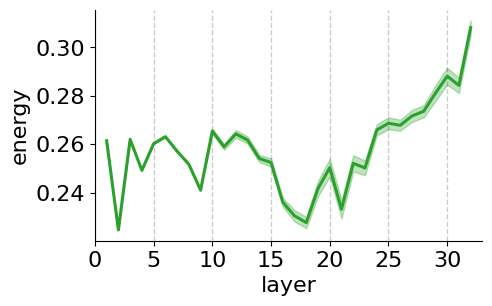

In [17]:
size2tik = {'7b': 5, '13b': 5, '70b': 10}

fig, ax2 = plt.subplots(figsize=(5,3))
plot_ci(ax2, energy, 'energy', color='tab:green', do_lines=True, tik_step=size2tik[model_size])
ax2.set_xlabel('layer')
ax2.set_ylabel('energy')
if model_size == '7b':
    ax2.set_xlim(0, out_token_probs.shape[1]+1)
else:
    ax2.set_xlim(0, round(out_token_probs.shape[1]/10)*10+1)
os.makedirs(f'{out_dir}/translation', exist_ok=True)
plt.savefig(f'{out_dir}/translation/{model_size}_{input_lang}_{target_lang}_energy.jpg', dpi=300, bbox_inches='tight')